In [19]:

#爬取标题及时间

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import re
import time

# 设置Selenium WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

titles = []
dates = []

# 爬取41页的内容
for i in range(0, 41):
    # 构造每页的URL
    page_url = f'https://finance.eastmoney.com/a/cgspl_{"" if i == 1 else str(i)}.html'
    driver.get(page_url)
    
    # 等待页面加载完成
    time.sleep(5)  # 实际情况中可能需要调整等待时间
    
    # 获取所有新闻条目的元素
    elements = driver.find_elements(By.CSS_SELECTOR, 'ul#newsListContent li')
    for element in elements:
        # 提取标题
        try:
            title_element = element.find_element(By.CSS_SELECTOR, 'p.title a')
            title = title_element.text if title_element else '标题缺失'
        except Exception as e:
            title = '标题缺失'
        titles.append(title)
        
        # 提取时间，并处理成年月日格式
        try:
            time_element = element.find_element(By.CSS_SELECTOR, 'p.time')
            full_time = time_element.text if time_element else '时间缺失'
            # 正则表达式匹配中文日期格式
            date_match = re.search(r'(\d{4})年(\d{1,2})月(\d{1,2})日', full_time)
            if date_match:
                # 构造格式化的日期字符串
                year, month, day = date_match.groups()
                date = f"{year}-{int(month):02d}-{int(day):02d}"  # 格式化为YYYY-MM-DD
            else:
                date = '日期格式错误'
        except Exception as e:
            date = '日期格式错误'
        dates.append(date)

# 关闭浏览器
driver.quit()

# 转换成DataFrame
data = pd.DataFrame({
    '标题': titles,
    '时间': dates
})

# 保存到CSV文件
data.to_csv('inital.csv', index=False, encoding='utf-8-sig')

print('数据爬取完毕并已保存到CSV文件。')

KeyboardInterrupt: 

In [1]:

#分析每条信息的情绪

import pandas as pd
from snownlp import SnowNLP

# 加载数据
data = pd.read_csv('inital.csv')

# 使用snownlp计算每个标题的情绪得分
data['sentiment'] = data['标题'].apply(lambda x: SnowNLP(x).sentiments)

# 保存包含情绪得分的数据到新的CSV文件
data.to_csv('inital_sentiment.csv', index=False)

#输出完成的标识
print('已经分析完成每条信息的情绪。')

已经分析完成每条信息的情绪。


In [9]:

#按日计算情绪总和及情绪计数

import pandas as pd
from snownlp import SnowNLP

# 加载数据
data = pd.read_csv('inital_sentiment.csv')

# 确保日期格式正确，如果需要的话可以进行转换
# data['时间'] = pd.to_datetime(data['时间'])

# 分组按照日期，并计算情绪得分的总和和计数
daily_sentiment = data.groupby('时间')['sentiment'].agg(['sum', 'count']).reset_index()

# 重命名列名以更清晰地表达数据内容
daily_sentiment.columns = ['日期', '情绪总和', '情绪计数']

# 保存结果
daily_sentiment.to_csv('inital_sentiment_sum.csv', index=False)
daily_sentiment


,日期,情绪总和,情绪计数
0,2024-01-06,1.305353,2
1,2024-01-07,0.999951,1
2,2024-01-08,4.333084,5
3,2024-01-09,0.724421,1
4,2024-01-10,2.991998,3
...,...,...,...
335,2025-03-07,2.812636,3
336,2025-03-08,2.953170,3
337,2025-03-09,4.978137,5
338,2025-03-10,5.271289,6


In [7]:

#爬取上证指数的涨幅度以及时间

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import re

# 初始化webdriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# 打开网页
driver.get('https://quote.eastmoney.com/zs000001.html#fullScreenChart')

# 使用显式等待，确保页面已加载
wait = WebDriverWait(driver, 20)

# 定位iframe元素并切换到该iframe
iframe = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'iframe[src*="full.html"]')))
driver.switch_to.frame(iframe)

# 点击“周k”功能标签
daily_k_tab = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "li[data-type='wk']")))
daily_k_tab.click()

# 等待“周k”界面加载
wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '#kchartbox')))

# 定位图表元素
chart_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox')
chart_width = chart_element.size['width']

# 准备通过在图表上移动鼠标来捕获数据点
data_points = []
num_days = 90  # 根据你的图表实际覆盖的天数进行调整

# 获取图表的起始位置
# 获取图表的起始位置，偏移量从中间开始
chart_left_offset = chart_element.location['x'] - chart_width / 2


# 假设每像素代表一天（这个比例需要根据实际图表调整）
pixels_per_day = chart_width / num_days

for day in range(num_days):
    action = ActionChains(driver)
    # 计算偏移量，从图表的左侧开始
    x_offset = chart_left_offset + day * pixels_per_day
    action.move_to_element_with_offset(chart_element, x_offset, 10).perform()
    time.sleep(0.5)  # 留出时间让悬浮窗口数据显示

    # 尝试捕获日期和涨跌幅数据
    try:
        date_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox > div.__ui > div.__popfloatwin > h4')
        change_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox > div.__ui > div.__popfloatwin > div:nth-child(6)')
        
        date = date_element.text.strip()
        change_text = change_element.text.strip()
        
        # 使用正则表达式提取涨跌幅数值
        change_match = re.search(r"[\+\-]\d+\.\d+%", change_text)
        if change_match:
            change = change_match.group()
        else:
            change = "N/A"  # 如果没有匹配到，可以赋一个默认值

        # 只有在日期和涨跌幅都成功捕获时才记录数据
        if date and change != "N/A":
            data_points.append((date, change))
           
    except Exception as e:
        # 如果某一天的数据捕获失败，打印错误并继续
        print("正在尝试保存数据")

# 完成抓取后，切换回主页面内容
driver.switch_to.default_content()

# 关闭浏览器
driver.quit()



# 将数据点转换为 Pandas DataFrame
data_frame = pd.DataFrame(data_points, columns=['日期', '涨跌幅'])

# 输出 DataFrame 到 CSV 文件
data_frame.to_csv('shangzheng.csv', index=False, encoding='utf-8-sig')

print("数据已成功保存到 CSV 文件。")


正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
数据已成功保存到 CSV 文件。


In [4]:

#爬取沪深300的涨幅度以及时间

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import re

# 初始化webdriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# 打开网页
driver.get('http://quote.eastmoney.com/zs000300.html#fullScreenChart')

# 使用显式等待，确保页面已加载
wait = WebDriverWait(driver, 20)

# 定位iframe元素并切换到该iframe
iframe = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'iframe[src*="full.html"]')))
driver.switch_to.frame(iframe)

# 点击“周k”功能标签
daily_k_tab = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "li[data-type='wk']")))
daily_k_tab.click()

# 等待“周k”界面加载
wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '#kchartbox')))

# 定位图表元素
chart_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox')
chart_width = chart_element.size['width']

# 准备通过在图表上移动鼠标来捕获数据点
data_points = []
num_days = 90  # 根据你的图表实际覆盖的天数进行调整

# 获取图表的起始位置
# 获取图表的起始位置，偏移量从中间开始
chart_left_offset = chart_element.location['x'] - chart_width / 2


# 假设每像素代表一天（这个比例需要根据实际图表调整）
pixels_per_day = chart_width / num_days

for day in range(num_days):
    action = ActionChains(driver)
    # 计算偏移量，从图表的左侧开始
    x_offset = chart_left_offset + day * pixels_per_day
    action.move_to_element_with_offset(chart_element, x_offset, 10).perform()
    time.sleep(0.5)  # 留出时间让悬浮窗口数据显示

    # 尝试捕获日期和涨跌幅数据
    try:
        date_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox > div.__ui > div.__popfloatwin > h4')
        change_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox > div.__ui > div.__popfloatwin > div:nth-child(6)')
        
        date = date_element.text.strip()
        change_text = change_element.text.strip()
        
        # 使用正则表达式提取涨跌幅数值
        change_match = re.search(r"[\+\-]\d+\.\d+%", change_text)
        if change_match:
            change = change_match.group()
        else:
            change = "N/A"  # 如果没有匹配到，可以赋一个默认值

        # 只有在日期和涨跌幅都成功捕获时才记录数据
        if date and change != "N/A":
            data_points.append((date, change))
           
    except Exception as e:
        # 如果某一天的数据捕获失败，打印错误并继续
        print("正在尝试保存数据")

# 完成抓取后，切换回主页面内容
driver.switch_to.default_content()

# 关闭浏览器
driver.quit()


# 将数据点转换为 Pandas DataFrame
data_frame = pd.DataFrame(data_points, columns=['日期', '涨跌幅'])

# 输出 DataFrame 到 CSV 文件
data_frame.to_csv('hushen300.csv', index=False, encoding='utf-8-sig')

print("数据已成功保存到 CSV 文件。")


数据已成功保存到 CSV 文件。


In [8]:

#爬取深证成指的涨幅度以及时间

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import re

# 初始化webdriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# 打开网页
driver.get('http://quote.eastmoney.com/zs399001.html#fullScreenChart')

# 使用显式等待，确保页面已加载
wait = WebDriverWait(driver, 20)

# 定位iframe元素并切换到该iframe
iframe = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'iframe[src*="full.html"]')))
driver.switch_to.frame(iframe)

# 点击“周k”功能标签
daily_k_tab = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "li[data-type='wk']")))
daily_k_tab.click()

# 等待“周k”界面加载
wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, '#kchartbox')))

# 定位图表元素
chart_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox')
chart_width = chart_element.size['width']

# 准备通过在图表上移动鼠标来捕获数据点
data_points = []
num_days = 90  # 根据你的图表实际覆盖的天数进行调整

# 获取图表的起始位置
# 获取图表的起始位置，偏移量从中间开始
chart_left_offset = chart_element.location['x'] - chart_width / 2


# 假设每像素代表一天（这个比例需要根据实际图表调整）
pixels_per_day = chart_width / num_days

for day in range(num_days):
    action = ActionChains(driver)
    # 计算偏移量，从图表的左侧开始
    x_offset = chart_left_offset + day * pixels_per_day
    action.move_to_element_with_offset(chart_element, x_offset, 10).perform()
    time.sleep(0.5)  # 留出时间让悬浮窗口数据显示

    # 尝试捕获日期和涨跌幅数据
    try:
        date_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox > div.__ui > div.__popfloatwin > h4')
        change_element = driver.find_element(By.CSS_SELECTOR, '#kchartbox > div.__ui > div.__popfloatwin > div:nth-child(6)')
        
        date = date_element.text.strip()
        change_text = change_element.text.strip()
        
        # 使用正则表达式提取涨跌幅数值
        change_match = re.search(r"[\+\-]\d+\.\d+%", change_text)
        if change_match:
            change = change_match.group()
        else:
            change = "N/A"  # 如果没有匹配到，可以赋一个默认值

        # 只有在日期和涨跌幅都成功捕获时才记录数据
        if date and change != "N/A":
            data_points.append((date, change))
           
    except Exception as e:
        # 如果某一天的数据捕获失败，打印错误并继续
        print("正在尝试保存数据")

# 完成抓取后，切换回主页面内容
driver.switch_to.default_content()

# 关闭浏览器
driver.quit()


# 将数据点转换为 Pandas DataFrame
data_frame = pd.DataFrame(data_points, columns=['日期', '涨跌幅'])

# 输出 DataFrame 到 CSV 文件
data_frame.to_csv('shenzheng.csv', index=False, encoding='utf-8-sig')

print("数据已成功保存到 CSV 文件。")


正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
正在尝试保存数据
数据已成功保存到 CSV 文件。


In [11]:

#调整inital_sentiment_sum数据的日期增长。
#调整为adjust

import pandas as pd

# 加载CSV文件
df = pd.read_csv('inital_sentiment_sum.csv')

# 确保日期列的数据类型是日期格式
df['日期'] = pd.to_datetime(df['日期'])

# 根据日期列进行排序，默认为升序
df_sorted = df.sort_values(by='日期')

# 保存排序后的数据到新的CSV文件
df_sorted.to_csv('adjust_sentiment_sum.csv', index=False)

In [12]:

#整合inital中的日期为一周，衔接的是上证指数

import pandas as pd

# 加载数据
one = pd.read_csv('adjust_sentiment_sum.csv')
two = pd.read_csv('shangzheng.csv')

# 转换日期格式
one['日期'] = pd.to_datetime(one['日期'])
two['日期'] = pd.to_datetime(two['日期'])

# 确定存在的周结束日期列表
available_dates = two['日期'].unique()

# 计算每条记录的实际周结束日期
def find_week_end(start_date, dates):
    for offset in range(7):
        possible_date = start_date + pd.Timedelta(days=offset)
        if possible_date in dates:
            return possible_date
    return None  # 如果一周内没有有效日期，返回None

# 应用函数计算周结束日期
one['周结束日期'] = one['日期'].apply(lambda x: find_week_end(x, available_dates))

# 汇总情绪得分和计数
weekly_summary = one.groupby('周结束日期').agg({'情绪总和':'sum', '情绪计数':'sum'}).reset_index()

# 合并数据
merged_two = two.merge(weekly_summary, left_on='日期', right_on='周结束日期', how='left')

# 填充NaN值
merged_two['情绪总和'].fillna(0, inplace=True)
merged_two['情绪计数'].fillna(0, inplace=True)

# 删除周结束日期列
merged_two.drop(columns=['周结束日期'], inplace=True)

# 保存合并后的数据
merged_two.to_csv('week_shangzheng.csv', index=False)

/var/folders/2t/0c56yyms5rddyr7pt02csbt00000gn/T/ipykernel_15577/4125108420.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_two['情绪总和'].fillna(0, inplace=True)
/var/folders/2t/0c56yyms5rddyr7pt02csbt00000gn/T/ipykernel_15577/4125108420.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [13]:

#整合inital中的日期为一周，衔接的是沪深300

import pandas as pd

# 加载数据
one = pd.read_csv('adjust_sentiment_sum.csv')
two = pd.read_csv('hushen300.csv')

# 转换日期格式
one['日期'] = pd.to_datetime(one['日期'])
two['日期'] = pd.to_datetime(two['日期'])

# 确定存在的周结束日期列表
available_dates = two['日期'].unique()

# 计算每条记录的实际周结束日期
def find_week_end(start_date, dates):
    for offset in range(7):
        possible_date = start_date + pd.Timedelta(days=offset)
        if possible_date in dates:
            return possible_date
    return None  # 如果一周内没有有效日期，返回None

# 应用函数计算周结束日期
one['周结束日期'] = one['日期'].apply(lambda x: find_week_end(x, available_dates))

# 汇总情绪得分和计数
weekly_summary = one.groupby('周结束日期').agg({'情绪总和':'sum', '情绪计数':'sum'}).reset_index()

# 合并数据
merged_two = two.merge(weekly_summary, left_on='日期', right_on='周结束日期', how='left')

# 填充NaN值
merged_two['情绪总和'].fillna(0, inplace=True)
merged_two['情绪计数'].fillna(0, inplace=True)

# 删除周结束日期列
merged_two.drop(columns=['周结束日期'], inplace=True)

# 保存合并后的数据
merged_two.to_csv('week_hushen300.csv', index=False)

/var/folders/2t/0c56yyms5rddyr7pt02csbt00000gn/T/ipykernel_15577/2354315949.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_two['情绪总和'].fillna(0, inplace=True)
/var/folders/2t/0c56yyms5rddyr7pt02csbt00000gn/T/ipykernel_15577/2354315949.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [14]:

#整合inital中的日期为一周，衔接的是深证成指

import pandas as pd

# 加载数据
one = pd.read_csv('adjust_sentiment_sum.csv')
two = pd.read_csv('shenzheng.csv')

# 转换日期格式
one['日期'] = pd.to_datetime(one['日期'])
two['日期'] = pd.to_datetime(two['日期'])

# 确定存在的周结束日期列表
available_dates = two['日期'].unique()

# 计算每条记录的实际周结束日期
def find_week_end(start_date, dates):
    for offset in range(7):
        possible_date = start_date + pd.Timedelta(days=offset)
        if possible_date in dates:
            return possible_date
    return None  # 如果一周内没有有效日期，返回None

# 应用函数计算周结束日期
one['周结束日期'] = one['日期'].apply(lambda x: find_week_end(x, available_dates))

# 汇总情绪得分和计数
weekly_summary = one.groupby('周结束日期').agg({'情绪总和':'sum', '情绪计数':'sum'}).reset_index()

# 合并数据
merged_two = two.merge(weekly_summary, left_on='日期', right_on='周结束日期', how='left')

# 填充NaN值
merged_two['情绪总和'].fillna(0, inplace=True)
merged_two['情绪计数'].fillna(0, inplace=True)

# 删除周结束日期列
merged_two.drop(columns=['周结束日期'], inplace=True)

# 保存合并后的数据
merged_two.to_csv('week_shenzheng.csv', index=False)

/var/folders/2t/0c56yyms5rddyr7pt02csbt00000gn/T/ipykernel_15577/1946450635.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_two['情绪总和'].fillna(0, inplace=True)
/var/folders/2t/0c56yyms5rddyr7pt02csbt00000gn/T/ipykernel_15577/1946450635.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [16]:

#将上证指数、沪深300以及深证成指合并。

import pandas as pd

# 加载数据
week_shangzheng = pd.read_csv('week_shangzheng.csv')
updated_shenzheng = pd.read_csv('week_shenzheng.csv')
updated_hushen300 = pd.read_csv('week_hushen300.csv')

# 统一日期格式
week_shangzheng['日期'] = pd.to_datetime(week_shangzheng['日期'], format='%Y-%m-%d')
updated_shenzheng['日期'] = pd.to_datetime(updated_shenzheng['日期'], format='%Y-%m-%d')
updated_hushen300['日期'] = pd.to_datetime(updated_hushen300['日期'], format='%Y/%m/%d')  # 注意格式

# 重命名每个表中的"涨跌幅"列
week_shangzheng.rename(columns={'涨跌幅': '上证指数'}, inplace=True)
updated_shenzheng.rename(columns={'涨跌幅': '深证成指'}, inplace=True)
updated_hushen300.rename(columns={'涨跌幅': '沪深300'}, inplace=True)

# 合并数据
merged_data = pd.merge(week_shangzheng, updated_shenzheng, on='日期', how='outer')
merged_data = pd.merge(merged_data, updated_hushen300, on='日期', how='outer')

# 去除重复的情绪总和和情绪计数列
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# 保存合并后的数据到新的CSV文件
merged_data.to_csv('merged_all_data.csv', index=False)


In [17]:

#求情绪均值

import pandas as pd

# 加载合并后的数据
merged_data = pd.read_csv('merged_all_data.csv')

# 计算情绪总和和情绪计数的商，并创建新的列“情绪均值”
# 使用适当的错误处理以避免除以零的情况
merged_data['情绪均值'] = merged_data['情绪总和'] / merged_data['情绪计数'].replace(0, pd.NA)

# 保存修改后的数据到新的CSV文件
merged_data.to_csv('adjust_all_data_.csv', index=False)


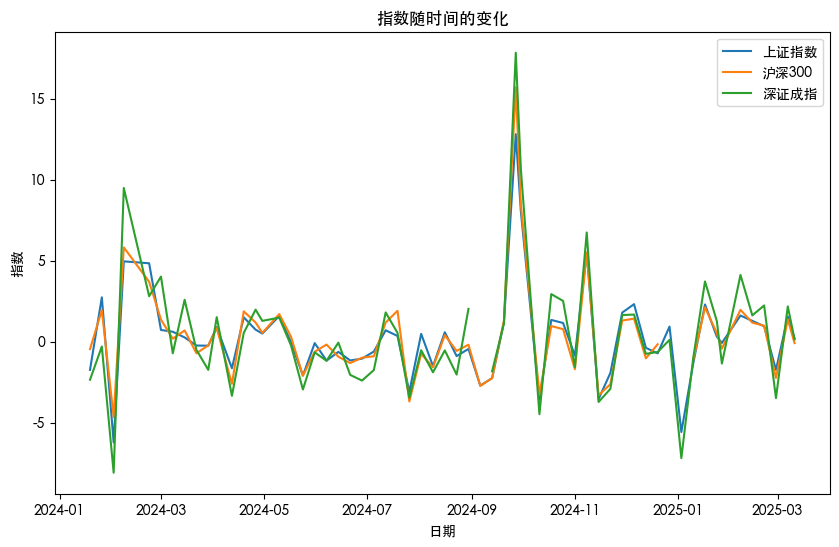

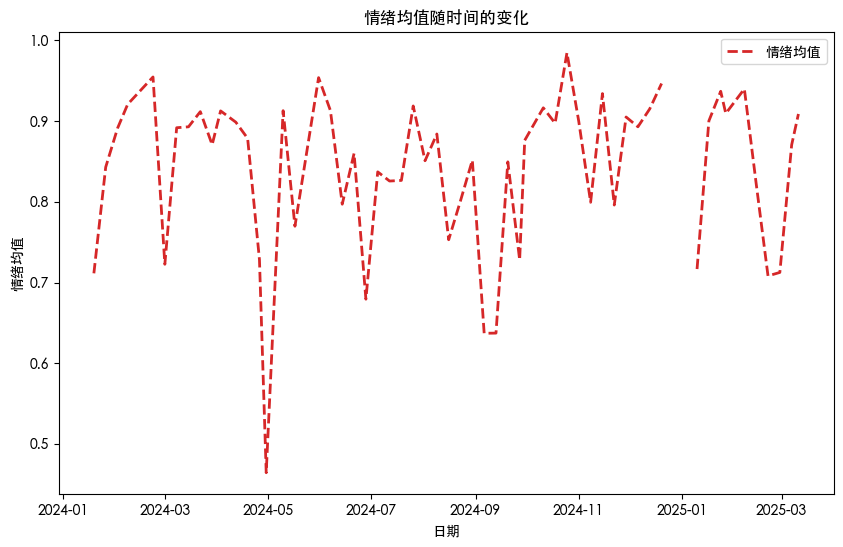

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 为matplotlib配置中文字体
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # 'SimHei' 是一个中文字体的名称
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 加载数据
data = pd.read_csv('adjust_all_data_.csv')

# 将日期列转换为日期类型，并设置为索引
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)

# 去除百分比符号并转换为浮点数
data['上证指数'] = data['上证指数'].str.replace('%', '').astype(float)
data['沪深300'] = data['沪深300'].str.replace('%', '').astype(float)
data['深证成指'] = data['深证成指'].str.replace('%', '').astype(float)

# 计算情绪均值，并处理除以零的情况
data['情绪均值'] = data['情绪总和'] / data['情绪计数'].replace({0: pd.NA})

# 绘制指数随时间的变化
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['上证指数'], label='上证指数')
plt.plot(data.index, data['沪深300'], label='沪深300')
plt.plot(data.index, data['深证成指'], label='深证成指')
plt.legend()
plt.title('指数随时间的变化')
plt.xlabel('日期')
plt.ylabel('指数')
plt.show()

# 单独绘制情绪均值随时间的变化
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['情绪均值'], label='情绪均值', color='tab:red', linestyle='--', linewidth=2)
plt.legend()
plt.title('情绪均值随时间的变化')
plt.xlabel('日期')
plt.ylabel('情绪均值')
plt.show()